# Variational Autoencoder as a One-Class audio classifier for dog bark detection

The goal of this project is to build a One-Class binary audio classifier capable to detect a specific dog bark. </br>
'One-Class' because the model is based on a CNN Variational Autoencoder trained and tested using samples from the positive class (dog bark) only. </br>
The VAE encoder input is the normalized Mel-scaled log spectrogram of the original audio signal while the reconstructed audio signal is obtained deoding the denormalized Mel-scaled log spectrogram at decoder output. </br>
After the VAE training-testing phase we perform three experiments in order to empirically evaluate the model:

1) reconstruction of a positive class sample (dog bark)
2) reconstruction of a negative class sample (enviromental sound sample taken from ESC-10 dataset)
3) generation of audio samples with input randomly taken from the latent space

Finally, the binary classification (dog bark vs all) is performed considering for each observation the two terms that contributes to the loss objective function used to train the VAE model: the reconstruction and the regularization loss, named respectively RL and KL. 

- RL corresponds to the MSE Loss between the normalized Mel-scaled log spectrograms at encoder input and decoder output and acts on the final layer of the model
- KL takes its name from the Kullback-Leibler Divergence from which it is derived with some math manipulation and acts on the latent layer of the model

## Variational Inference

Variational Bayeisan (VB) Methods are a family of techniques that are very popular in statistical Machine Learning. VB methods allow us to re-write statistical inference problems (i.e. infer the value of a random variable given the value of another random variable) as optimization problems (i.e. find the parameter values that minimize some objective function) that can be solved using Deep Learning tools.

In statistical inference, let:

- p(X) be the probability distribution of the data we want to model
- p(z) be the probability distribution of the latent variable - aka the *prior*
- p(X|z) be the distribution of generating data given the latent variable - aka the *likelihood*
- p(z|X) be the distribution of generating latent variable values given the observed data - aka the *posterior*

In our VAE model we make the following assumptions:

- Prior : choose this to be a simple distribution, i.e. a Standard Gaussian and so $p(z) \sim N(0,I_d)$ (It can be shown that a simple distribution such as the Standard Normal can be mapped into very complicated distributions as long as the mapping function is sufficiently complex, e.g. a neural network)
- Likelihood : represents the decoder part of our network so can be easily parameterized: depending on the problem it can be for example a multivariate Bernoulli (e.g. input is an image with pixel values $\in {0,1}$) or a Gaussian (e.g. input is an audio signal spectrogram with real coefficients). The reconstruction part of the loss function will be computed with BCE in the former case and with MSE in the latter.
- Posterior :  represents the encoder part of our network. For Bayes' Theorem can be written as $p(z|X) = \frac{p(X|z)p(z)}{\int_z p(X|z)p(z)dz}$. Unfortunately the integral at denominator is often intractable so we don't have an analytical solution. The solution is to approximate the real posterior with an easy, parametric distribution $q_\phi(𝑧|𝑋)$ 

## Posterior approximation
We choose  $q_\phi(𝑧|𝑋)$ to be an infinite mixture of diagonal multivariate Gaussians: $q_\phi(𝑧|𝑋) \sim N(\mu_\phi(X), diag(\sigma^2_\phi(X))$ and we want to chose the set of parameters $\phi$ that makes $q_\phi(𝑧|𝑋)$ the best approximation of the real posterior $p(z|X)$: 
</br>
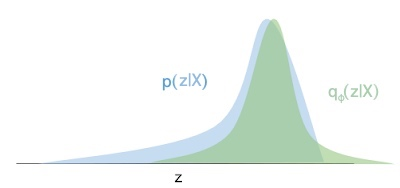
</br>
This is achieved minimizing on $\phi$ ther Kullback-Leibler Divergence (KL) between $q_\phi(𝑧|𝑋)$ and $p(z|X)$. </br> 
KL divergence measures the dissimilarity between two distributions ($KL = 0$ when they are exaclty the same).
</br>
KL divergence in our case is:
</br>
$$KL(q_\phi(z|X)||p(z|X)) = \sum_z{q_\phi(z|X)log{\frac{q_\phi(z|X)}{p(z|X)}}}$$
</br>
With some math we end up with the formulation of the VAE objective function(we want to minimize): </br>
</br>
$$KL(q_\phi(z|X)||p(z|X)) = \sum_z{q_\phi(z|X)log{\frac{q_\phi(z|X)}{p(z|X)}}}
                        = \sum_z{q_\phi(z|X)log{\frac{q_\phi(z|X)p(X)}{p(z,X)}}} 
                        = \sum_z{q_\phi(z|X)(log{\frac{q_\phi(z|X)}{p(z,X)}} + log{p(X)})}
                        = \sum_z{q_\phi(z|X)log{\frac{q_\phi(z|X)}{p(z,X)}}} + log{p(X)}
                        = -\ell + log{p(X)}$$
</br>
Rearranging this final equation:
</br>
$$log{p(X)} = \ell + KL(q_\phi(z|X)||p(z|X))$$
</br>
The model goal is to maximize the log likelihood of data $log{p(X)}$ and since $KL(q_\phi(z|X)||p(z|X)) > 0$ by definition, this is equivalent to maximize $\ell$. For this reason $\ell$ is known in literature as the *variational lower bound*, and is computationally tractable if we can evaluate $p(X|z),p(z),q_\phi(z|X)$ which is what exactly happens thanks to the assumptions we made on these distributions. </br>
We can further re-arrange the $\ell$ term in a way that yields an intuitive formula: </br>
</br>
$$\ell = - \sum_z{q_\phi(z|X)log{\frac{q_\phi(z|X)}{p(z,X)}}}
       = - \sum_z{q_\phi(z|X)log{\frac{q_\phi(z|X)}{p(X|z)p(z)}}}
       = \sum_z{q_\phi(z|X)log(p(X|x)} - \sum_z{q_\phi(z|X)log{\frac{q_\phi(z|X)}{p(z)}}}
       = E_{q_\phi(z|X)}[log(p(X|z)] - KL(q_\phi(z|X)||p(z))
       = RL + KL$$
</br>
Here's that $\ell$ can be split in the two already mentioned terms, the *reconstruction loss* RL and the *regulatization loss* KL. </br>

## VAE objective function: reconstruction and regularization losses

1. Reconstruction Loss (RL):
    - In traditional autoencoders we use L2 loss
    - With binary data it turns out to Binary Cross Entropy loss
    - With real valued data it turns out to Mean Squared Error loss.
2. Regularization Loss (KL):
    - You don’t want the latent variable values to be all over the place
    - Centered around 0 is a good place to start $\longrightarrow$ $p(z) \sim N(0,I_d)$
    - Without the KL term, VAE would act as a classic autoencoder, it may lead to overfitting and we won’t have the generative properties.

## VAE model architecture

The final architecture of our VAE model is shown below: </br>
 </br>
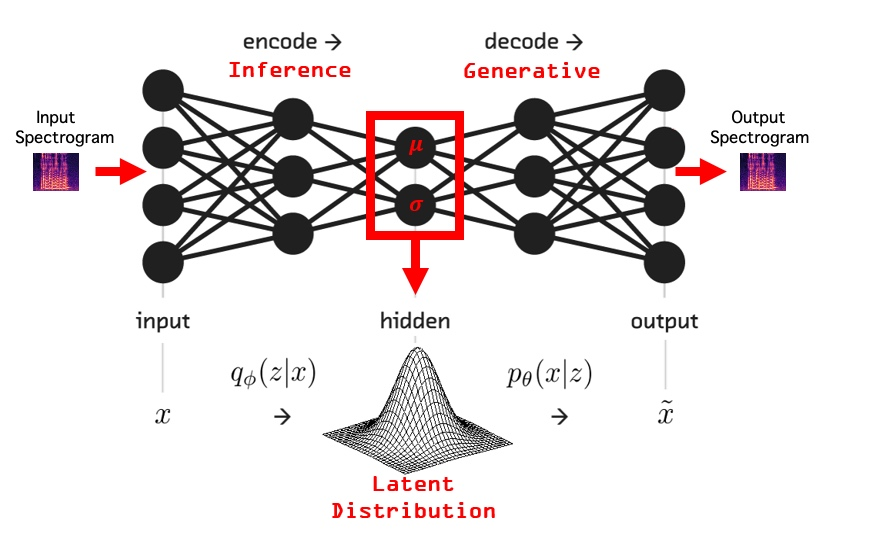
 </br>
 The VAE models the parameters of $q_\phi(𝑧|𝑋) \sim N(\mu_\phi(X), diag(\sigma^2_\phi(X))$ with a neural network that outputs a vector of means $\mu$ and a vector of variances $\sigma^2$ for each data point $X_i$.



## Optimization

The neural network weights are updated via SGD to maximize the objective function discussed previously, the *ELBO* or *Evidence Lower BOund* composed by reconstruction and regulatization losses. </br>
Performing gradient descent on the RL term presents complications: computing the actual expectation over $q_\phi$ requires an intractable integral (i.e., computing $logp(X|z)$ for all possible values of z). Fortunately this expectation can be approximated with Monte Carlo sampling which states that the expectation of a function can be approximated by the average value of the function across $N_s$ samples from the distribution: </br>
</br>
$$E_{q_\phi(z|X)}[log(p(X|z)] \approx \frac{1}{N_s} \sum_{s=1}^{N_s}logp(X|z_s)$$
</br>
In the case of the VAE we approximate the expectation using the single sample $z_s$ from $q_\phi(z|X)$. This is an unbiased estimate that converges over the training loop. Since $p(X|z)$ follows a Normal distribution, $logp(X|z)$ can be substituted with with MSE between the originl and the reconstructed sample. </br>
The KL or regularization term in the ELBO can be written (after a lot of math) in the simple and closed form as follows thanks to our assumptions for $q_\phi(z|X)$ and $p(z)$: </br>
</br>
$$- KL(q_\phi(z|X)||p(z)) = - KL(N(\mu,\sigma^2)||N(0,1)) 
                          = \int \frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{(x-\mu)^2}{\sqrt{2\pi\sigma^2}}}log{\frac{\frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{(x-\mu)^2}{\sqrt{2\pi\sigma^2}}}}{\frac{1}{\sqrt{2\pi}}e^{\frac{x^2}{\sqrt{2\pi}}}}}dz1
                          = ... = \frac{1}{2}\sum_{i=1}^d(1 + log\sigma_i^2 - \sigma_i^2 - \mu^2)$$ </br>
</br>
where $d$ in the sum is the latent space dimension. </br>
Therefore the full VAE loss objective function for a single batch of $N_s$ samples is: </br>
</br>
$$\ell = E_{q_\phi(z|X)}[log(p(X|z)] - KL(q_\phi(z|X)||p(z)) \approx \frac{1}{N_s} \sum_{s=1}^{N_s}logp(X|z_s) + \frac{1}{2}\sum_{i=1}^d(1 + log\sigma_i^2 - \sigma_i^2 - \mu^2)$$ </br>

## Reparameterisation trick

Another gradient descent-related complication is the sampling step that occurs between the encoder and the decoder. Without getting into the details, directly sampling $z$ from $q_\phi(z|X)$ introduces a discontinuity that cannot be backpropogated through. </br>
</br>
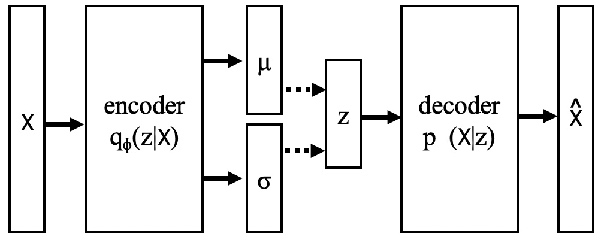
</br>
The neat solution to this is called the reparameterization trick, which moves the stochastic operation to an input layer and results in continuous linkage between the encoder and decoder allowing for backpropogation all the way through the encoder. Instead of sampling directly from the encoder $z_i \sim q_\phi(z_i|X_i)$ we can represent $z_i$ as a deterministic function of $X_i$ and some noise $\epsilon_i$: </br>
</br>
$$z_i = g_\phi(X_i, \epsilon_i) = \mu_\phi(X_i) + diag(\sigma_\phi(X_i)) * \epsilon_i$$
$$\epsilon_i \sim N(0,I_d)$$
</br>
You can show that $z$ defined in this way follows the distribution $q_\phi(z|X)$.
</br>
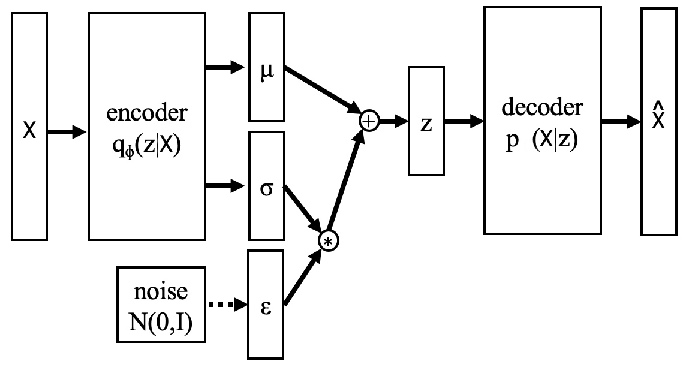

## Undestanding Mel-scaled spectrograms

### Signals
A signal is a variation of a given quantity over time. For audio, the quantity that varies is air pressure. In a digital audio signal we take samples of the air pressure over time. The rate at which we sample the data can vary, but is most commonly 44.1kHz, or 44,100 samples per second. What we have captured is a *waveform* for the signal:</br>
</br>
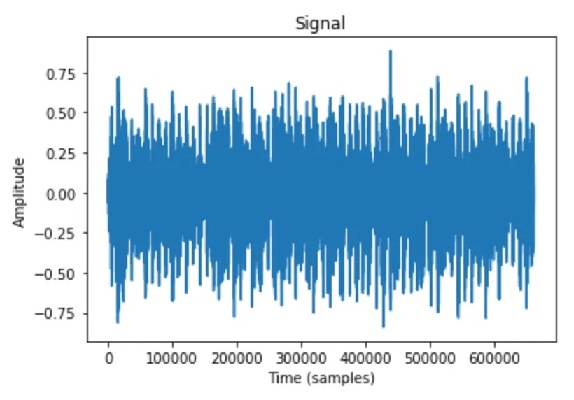
</br>
### The Fourier Transform
An audio signal can be decomposed into a set of sine and cosine waves that add up to the original signal. This is a remarkable theorem known as *Fourier’s theorem*. Each sine or cosine wave is an impulse in the frequency domain. The *Fourier Transform* is a mathematical formula that allows us to decompose a signal into it’s individual frequencies and the frequency’s amplitude. In other words, it converts the signal from the time domain into the frequency domain. The result is called *spectrum*. </br>
</br>
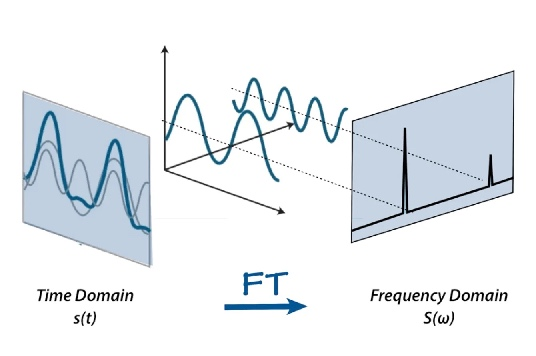
</br>
### The Spectrogram
The *Fast Fourier transform (FFT)* is an algorithm that can efficiently compute the *Fourier Transform* and is widely used in signal processing. FFT allows us to analyze the frequency content of a signal, but what if our signal’s frequency content varies over time, such as in non periodic signals? In order to represent the spectrum of these signals as they vary over time the FFT is performed on several windowed segments of the signal. This operation is called *Short-Time Fourier Transform (STFT)*. The wholw procedure is shown here below:</br>
</br>
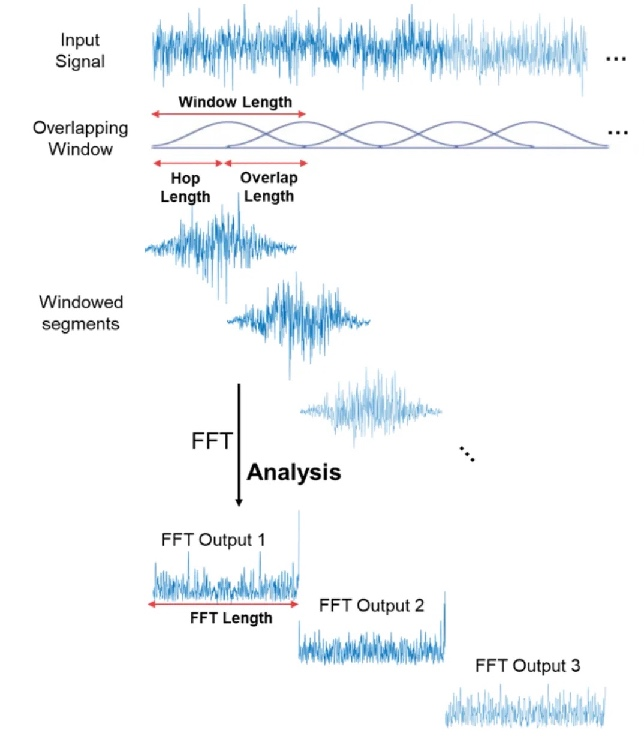
</br>
The graphical representation on a time-frequency diagram of the adjacent FFTs computed on overlapping windowed segments of the signal is called *spectrogram*. </br>
</br>
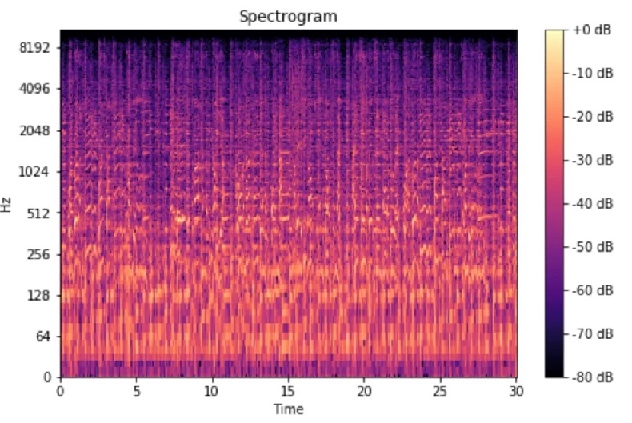
</br>
### The Mel Scale
Studies have shown that humans do not perceive frequencies on a linear scale. We are better at detecting differences in lower frequencies than higher frequencies. For example, we can easily tell the difference between 500 and 1000 Hz, but we will hardly be able to tell a difference between 10,000 and 10,500 Hz, even though the distance between the two pairs are the same. In 1937, Stevens, Volkmann, and Newmann proposed a unit of pitch such that equal distances in pitch sounded equally distant to the listener. This is called the *Mel Scale*. We perform a mathematical operation on frequencies to convert them to the *Mel Scale*: </br>
</br>
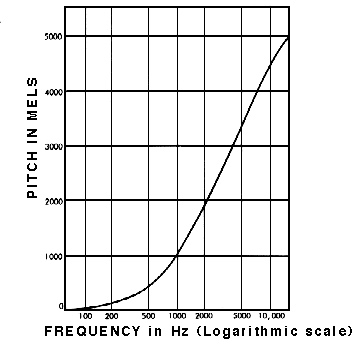
</br>
### The Mel Spectrogram
Intuitive enough, *Mel Spectrogram* is a spectrogram where the frequencies are converted to the mel scale.

In [1]:
import torch
from torch.utils.data import DataLoader
from torch import nn
from utils.CustomAudioDataset import CustomAudioDataset, LogSpectrogramExtractor, MinMaxNormalizer
from utils.VariationalAutoEncoder import VAE
from utils.write_csv import write_csv
from utils.functions import train_test_dataset, extract_dataset
from utils.functions import plot_data, plot_model, set_default
from utils.functions import save_model, load_model, save_loss, load_loss, plot_loss
from utils.functions import logspec_to_audio, plot_audio, plot_logspec
from utils.functions import compute_RL_KL, plot_RL_KL
from torchaudio import transforms
from fastaudio.core.all import *
import numpy as np
from matplotlib import pyplot as plt
import os
import librosa
import soundfile as sf
import random
import pandas as pd
import re
import math

In [2]:
# Setting the audio file duration correspond to use one fo the following audio files folder: 
# barks_1s, barks_2s or barks_3s so the only allowed values for the duration parameter are 1, 2 or 3

duration = 3 # allowed values: 1, 2, 3.
audio_folder = 'barks_' + str(duration) + 's'

# N_MELS is the number of Mel-scaled frequency bins.
N_MELS=128
# HOP_LENGTH is the number of non-overlapping samples in a time window.
HOP_LENGTH=512

# full dataset contains bark samples in audio_folder as well as all the enviromental sound samples in ESC-10 dataset.
full_dataset = CustomAudioDataset(duration = duration, 
                                  extractor = LogSpectrogramExtractor(N_MELS, HOP_LENGTH),
                                  normalizer = MinMaxNormalizer(0, 1))

In [3]:
# extract all bark samples from full_dataset and create a subset dataset
barks_dataset = extract_dataset(duration, 
                                LogSpectrogramExtractor(N_MELS, HOP_LENGTH), 
                                MinMaxNormalizer(0, 1), 
                                'bark')

# extract all enviromental sound samples from full_dataset and create a subset dataset
env_dataset = extract_dataset(duration,
                              LogSpectrogramExtractor(N_MELS, HOP_LENGTH), 
                              MinMaxNormalizer(0, 1), 
                              'bark', 
                              invert_match=True)

# split the bark samples subset in train and test datasets
datasets = train_test_dataset(barks_dataset, test_split=0.3)

In [4]:
# Setting the device
if hasattr(torch.backends, "mps"):
    if (torch.backends.mps.is_available() and torch.backends.mps.is_built()):
        device = torch.device("mps")
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
print(device)

mps


In [5]:
## Define data loading steps
num_workers = 4 if re.search("cuda", str(device)) else 0
batch_size = 64

train_loader = DataLoader(datasets['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(datasets['test'], batch_size=batch_size, shuffle=True, num_workers=num_workers)
env_loader = DataLoader(env_dataset, batch_size=len(env_dataset), shuffle=True, num_workers=num_workers)

In [6]:
logspec, _, _, _ , _ = next(iter(train_loader))

# n_hops is the number of windowed segments of HOP_LENGTH samples obtained splitting the audio sample before STFTs computation
# n_hops=130 for 3 seconds of WAV audio at sampling rate of 22050 Hz and HOP_LENGTH=512: ⌈3*22050/512⌉=130
n_hops = logspec.shape[-1]    

In [7]:
# define all parameters required by encoder and decoder convolutions:
input_shape=(1, N_MELS, n_hops)
conv_filters=[512, 256, 128, 64, 32]
conv_kernels=[3, 3, 3, 3, 3]
conv_strides=[2, 2, 2, 2, 1]
latent_space_dim=128
    
model = VAE(input_shape,
              conv_filters,
              conv_kernels,
              conv_strides,
              latent_space_dim)

VAE loss function is the sum of the two weighted terms:
1) Reconstruction Loss (RL)
2) Regularization Loss (KL)

RL loss with defined model is orders of magnitude lower than KL loss. </br>
Without a proper RL weight the optimization process would push down too much KL loss term. </br>
This results in very small logvar values and so very low variance for decoded output. </br>
VAE decoder acts like a lowpass filter and the net result is a very poor reconstruction (output is almost noise).

In [8]:
RL = nn.MSELoss()

def loss_function(x_hat, x, mu, logvar, RL_weight, β=1):

    KL = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
    
    return RL_weight * RL(x_hat, x) + β * KL

In [9]:
# Training and testing the VAE
def train_test_VAE(model, RL_weight):
    
    print('Training and testing with RL_weight: {:.0e}'.format(RL_weight))

    epochs = 50

    # EARLY STOPPING FIRST CRITERIA: : stop as soon as the generalization loss exceeds a certain threshold (alpha):
    # stop when GL_alpha > alpha
    alpha = 30
    GL_alpha = 0.

    # EARLY STOPPING SECOND CRITERIA: use the quotient of generalization loss and progress
    # stop when avg(E_tr) is less than 10% higher than min(E_tr)(P_kappa < 100):
    kappa=5
    P_kappa = 1000
    E_tr_arr = []

    # loss history
    y_loss = {} 
    y_loss['train'] = []
    y_loss['test'] = []
    y_loss['train_RL'] = []
    y_loss['train_KL'] = []

    model.to(device)
    model._reset_params()
    model.zero_grad()

    # Setting the optimiser
    learning_rate = 1e-2
    weight_decay = 5e-4

    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate,
                                 weight_decay=weight_decay)

    for epoch in range(0, epochs + 1):
    
        # Training
        if epoch > 0:  # test untrained net first
            model.train()
            train_loss = 0
            rec_loss = 0
            reg_loss = 0
            for x, _, _, _, _ in train_loader:
                x = x.to(device)          
                # ===================forward=====================
                x_hat, mu, logvar = model(x)
                loss = loss_function(x_hat, x, mu, logvar, RL_weight)
                train_loss += loss.item()
                rec_loss += RL(x_hat, x).item()
                reg_loss += (0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))).item()
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            # ===================log========================
            print(f'====> Epoch: {epoch} Average train loss: {train_loss:.4f}')
            print(f'====> Epoch: {epoch} Average reconstruction loss: {rec_loss:.4f}')
            print(f'====> Epoch: {epoch} Average regularization loss: {reg_loss:.4f}')
            y_loss['train'].append(train_loss / len(train_loader.dataset))
            y_loss['train_RL'].append(rec_loss / len(train_loader.dataset))
            y_loss['train_KL'].append(reg_loss / len(train_loader.dataset))
            E_tr_arr.append(train_loss)
        
        # Testing
        with torch.no_grad():
            model.eval()
            test_loss = 0
            for x, _, _, y, _ in test_loader:
                x = x.to(device)
                # ===================forward=====================
                x_hat, mu, logvar = model(x)
                test_loss += loss_function(x_hat, x, mu, logvar, RL_weight).item()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average test loss: {test_loss / len(test_loader.dataset):.4f}')
        if epoch > 0: y_loss['test'].append(test_loss / len(test_loader.dataset)) 
    
        if epoch == 0:
            E_opt = test_loss
        else:
            if test_loss < E_opt: E_opt = test_loss
        
        GL_alpha = 100 * (test_loss/E_opt -1)

        if epoch >= kappa:
            E_tr_slice = E_tr_arr[epoch - kappa:]
            E_tr_avg = sum(E_tr_slice) / len(E_tr_slice) 
            E_tr_min = min(E_tr_slice)
            P_kappa = 1000 * (E_tr_avg/E_tr_min -1)
            print("GL_alpha = " + str(GL_alpha))
            print("P_kappa = " + str(P_kappa))
            print("E_tr_avg = " + str(E_tr_avg))
            print("E_tr_min = " + str(E_tr_min))
            if (GL_alpha > alpha and P_kappa < 100) or (E_tr_avg < 1.1 * E_tr_min):
                break
                
    return y_loss

In [ ]:
#########################################################
# models and losses already computer for 
# RL_weight in np.logspace(0, 10, num=10, endpoint=False)
#########################################################

for RL_weight in np.logspace(0, 10, num=10, endpoint=False):
    # Training and testing VAE model using RL_weight in loss function
    y_loss = train_test_VAE(model, RL_weight)
    # load loss dictionary to a .pkl file with RL_weight as suffix
    save_loss(y_loss, device, RL_weight)
    # Save computed model in 'saved_models' directory
    save_model(audio_folder, model, device, RL_weight)

In [11]:
# 'decoded_audio' directory is used to store audio samples decoded using the computed VAE model
output_folder = os.getcwd() + '/decoded_audio'

#instantiate the normalizer
normalizer = MinMaxNormalizer(0, 1)

In [12]:
# prepare the test bark dataset
test_loader_dataset = test_loader.dataset.dataset.audio_ds
test_loader_indices = test_loader.dataset.indices
test_dataset = test_loader_dataset.loc[test_loader_dataset.index[test_loader_indices]]
test_dataset = test_dataset.dropna().reset_index(drop=True)

### 2-D plot of VAE regularization loss KL vs reconstruction loss RL
It is worth noting:
1) how compact are the points for the test barks dataset: this demonstrates how well this model works as a One-Class audio classifier.
2) the model is specialized in detecting the barking of a specific dog: the red points refer to generic dog barks from ESC-10, still the model is able to clearly distinguish those barks from the barks of the specific dog under observation

model successfully loaded from file barks_3s_mps_1e+00.pth


/opt/homebrew/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([128, 130])) that is different to the input size (torch.Size([1, 1, 128, 130])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/var/folders/tt/c1w5rnl91l3bvv13d_l1jgrm0000gp/T/ipykernel_8814/696092657.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_ds = test_bark_ds.append(test_env_ds, ignore_index=True)


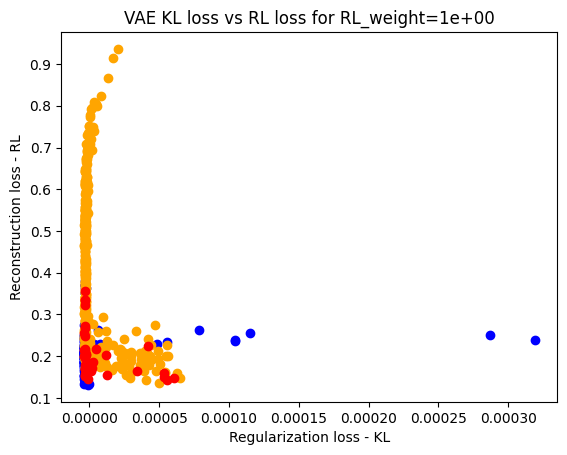

model successfully loaded from file barks_3s_mps_1e+01.pth


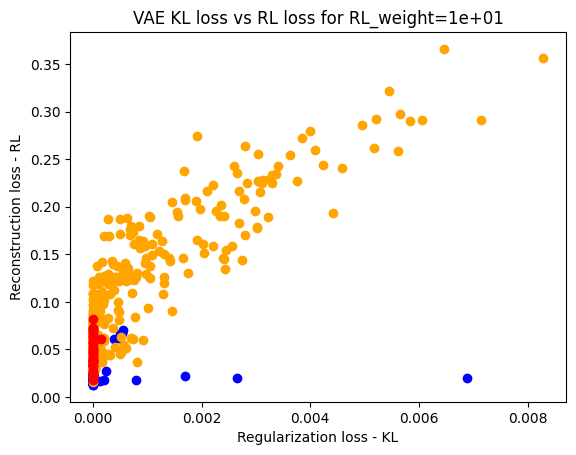

model successfully loaded from file barks_3s_mps_1e+02.pth


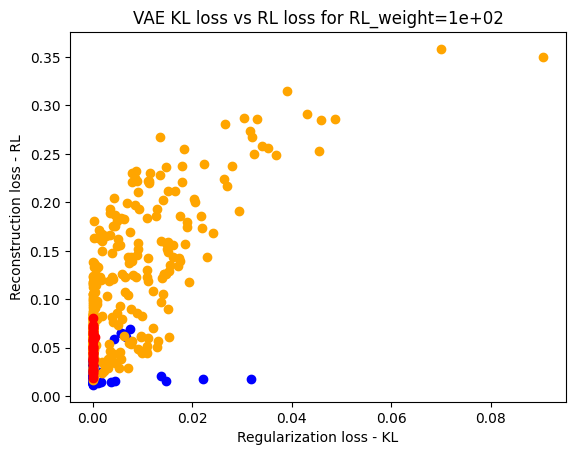

model successfully loaded from file barks_3s_mps_1e+03.pth


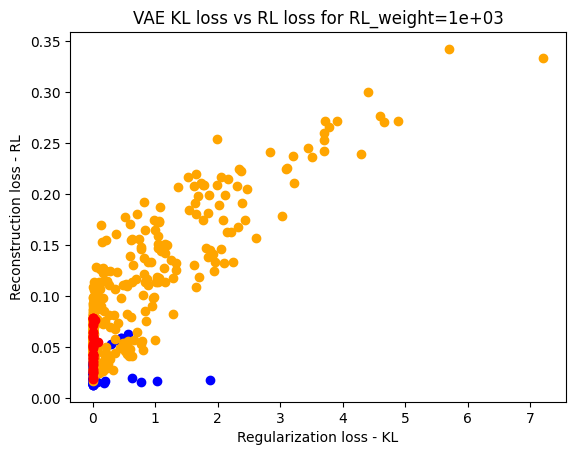

model successfully loaded from file barks_3s_mps_1e+04.pth


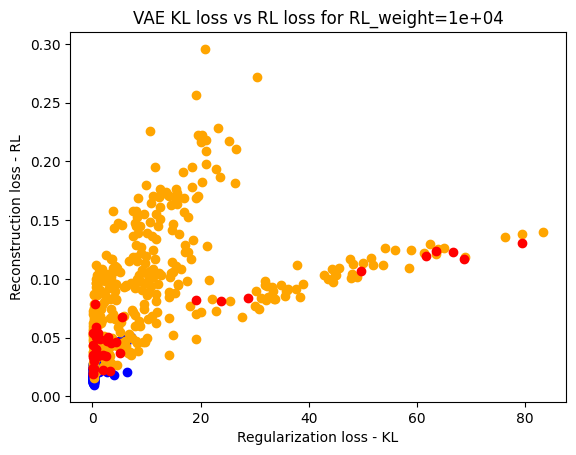

model successfully loaded from file barks_3s_mps_1e+05.pth


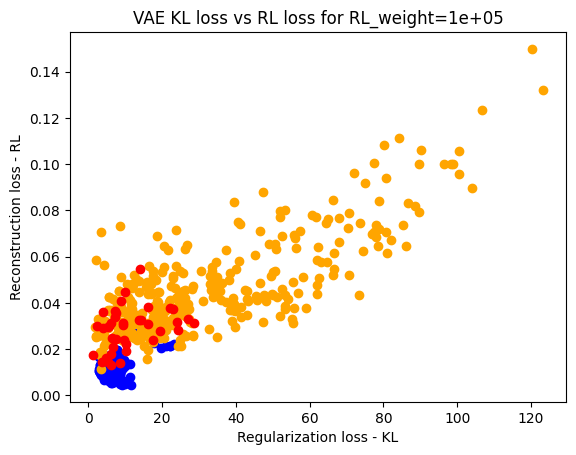

model successfully loaded from file barks_3s_mps_1e+06.pth


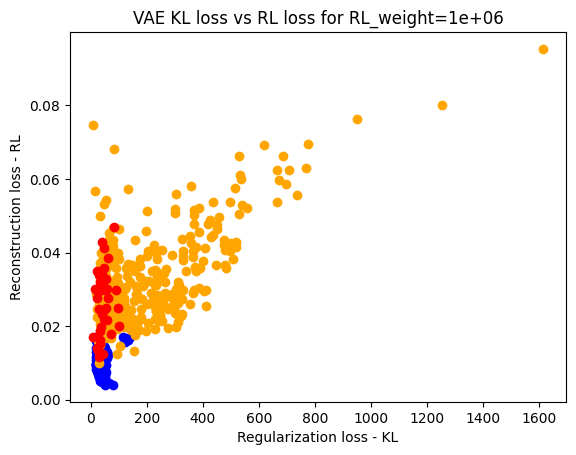

model successfully loaded from file barks_3s_mps_1e+07.pth


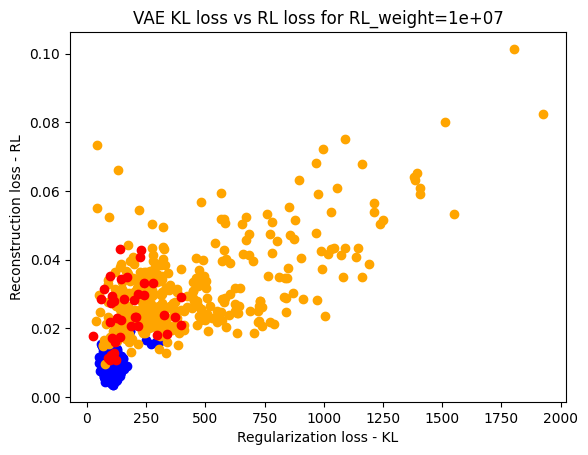

model successfully loaded from file barks_3s_mps_1e+08.pth


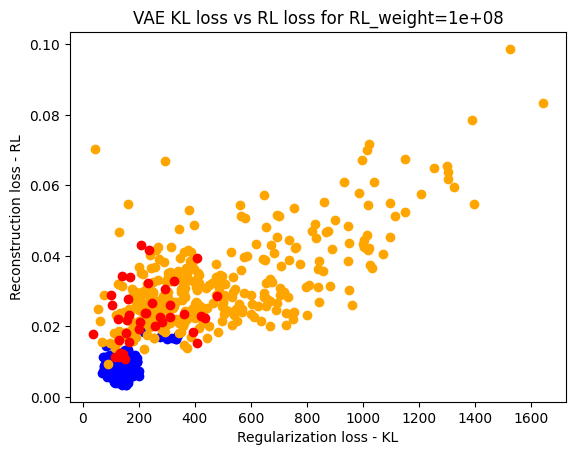

model successfully loaded from file barks_3s_mps_1e+09.pth


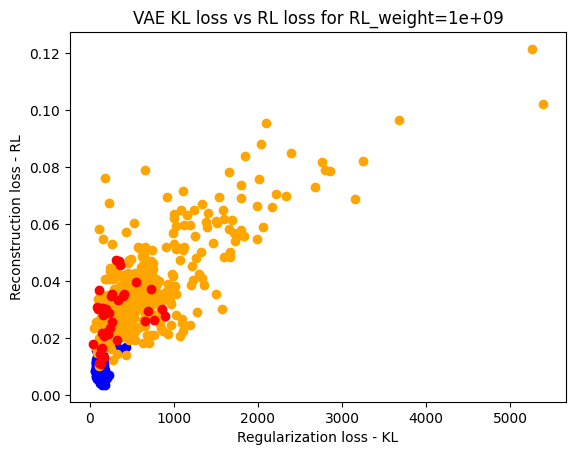

In [13]:
RL_test_bark_mean = []
KL_test_bark_mean = []

for RL_weight in np.logspace(0, 10, num=10, endpoint=False):
    
    # Load a previously computed model from 'saved_models' directory
    model = load_model(audio_folder,
                       input_shape,
                       conv_filters,
                       conv_kernels,
                       conv_strides,
                       latent_space_dim,
                       device,
                       RL_weight)
    
    # computes the RL, KL and label arrays for test barks dataset and enviromental sounds dataset
    RL_test_bark, KL_test_bark, mu_test_bark, logvar_test_bark, bark_labels = compute_RL_KL(model, 
                                                                                            device, 
                                                                                            normalizer, 
                                                                                            test_dataset)
    RL_test_env, KL_test_env, _, _, env_labels = compute_RL_KL(model, 
                                                               device, 
                                                               normalizer, 
                                                               env_dataset.audio_ds)
    
    RL_test_bark_mean.append(np.mean(RL_test_bark))
    KL_test_bark_mean.append(np.mean(KL_test_bark))

    # merge the three numpy arrays, add headers and transform the dictionary into pandas dataframe
    # for both test barks dataset and enviromental sounds dataset
    test_bark_data = {"RL": RL_test_bark,
                      "KL": KL_test_bark,
                      "class": bark_labels}

    test_env_data = {"RL": RL_test_env,
                     "KL": KL_test_env,
                     "class": env_labels}

    test_bark_ds = pd.DataFrame(test_bark_data)
    test_env_ds = pd.DataFrame(test_env_data)

    # merge the two dataframes
    test_ds = test_bark_ds.append(test_env_ds, ignore_index=True)
    test_ds = test_ds.dropna().reset_index(drop=True)
    
    plot_RL_KL(test_ds, RL_weight)

## 2-D plot of test dataset mean RL and KL losses vs RL loss weight
The two plots below show how reconstruction loss improves for high values of RL_weight. </br>
This improvements starts to become negligible for RL_weight > 1e05. </br>
The minimum is for RL_weight = 1e08, we will use this value in the following three experiments. </br>

Text(0.5, 0.01, 'log(RL_weight)')

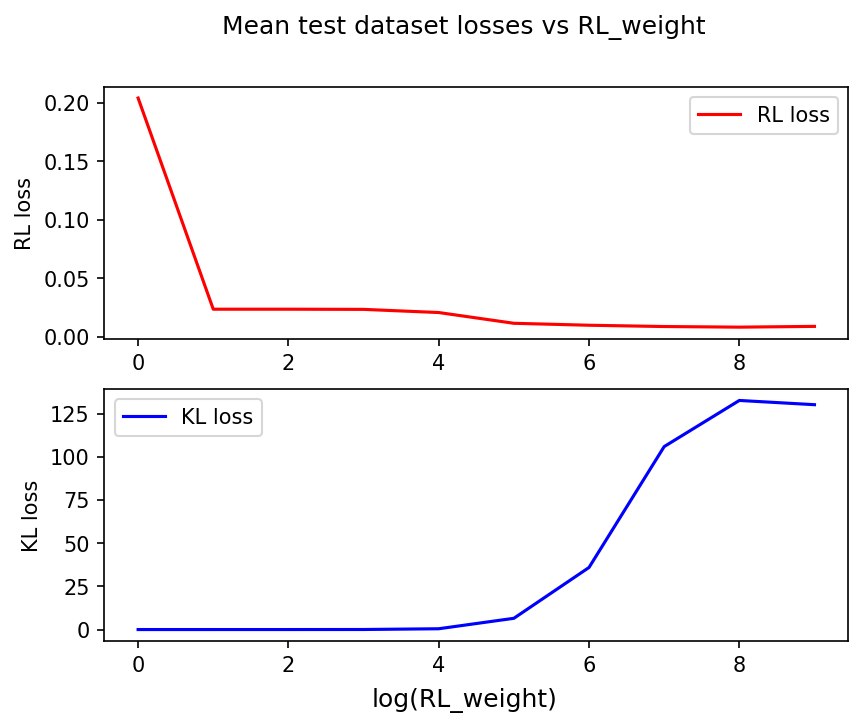

In [14]:
X = np.arange(0, 10, 1)

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Mean test dataset losses vs RL_weight')
fig.set_dpi(150)

ax1.plot(X,  RL_test_bark_mean, color='r', label='RL loss')
ax1.set(ylabel='RL loss')
ax1.legend()
ax2.plot(X,  KL_test_bark_mean, color='b', label='KL loss')
ax2.set(ylabel='KL loss')
ax2.legend()
fig.supxlabel('log(RL_weight)')

In [15]:
# set RL_weight
RL_weight = 1e08

In [16]:
# Load a previously computed model from 'saved_models' directory
model = load_model(audio_folder,input_shape,conv_filters,conv_kernels,conv_strides,latent_space_dim,device,RL_weight)

model successfully loaded from file barks_3s_mps_1e+08.pth


In [17]:
# load loss dictionary from .pkl file with RL_weight as suffix
y_loss = load_loss(device, RL_weight)

dictionary imported successfully from file loss_RL_weight_mps_1e+08.pkl


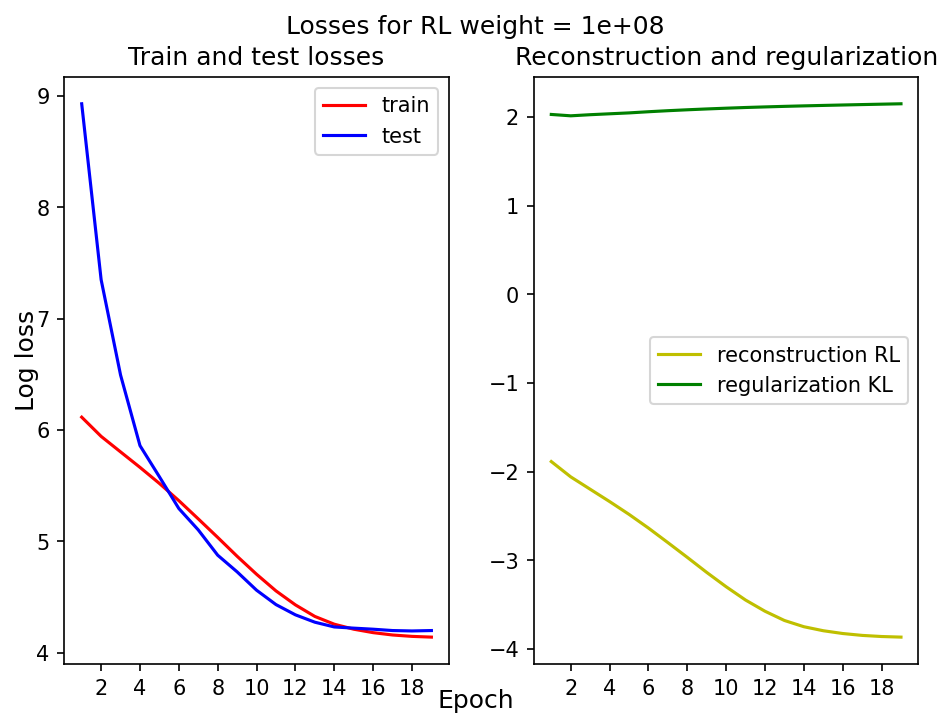

In [18]:
plot_loss(y_loss, RL_weight)

MSE Loss: tensor(18.6017)


/opt/homebrew/lib/python3.10/site-packages/fastaudio/core/signal.py:85: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/python_arg_parser.cpp:354.)
  display(Audio(self.cpu(), rate=self.sr))


/opt/homebrew/lib/python3.10/site-packages/torch/_tensor.py:915: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/python_arg_parser.cpp:354.)
  if self.dim() == 0:
/opt/homebrew/lib/python3.10/site-packages/torch/_tensor.py:926: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/python_arg_parser.cpp:354.)
  return iter(self.unbind(0))
/opt/homebrew/lib/python3.10/site-packages/fastaudio/core/signal.py:77: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/

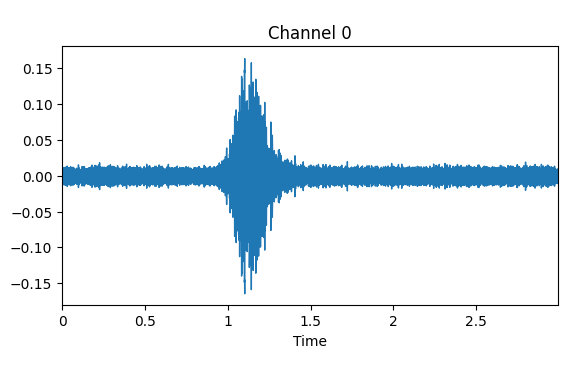

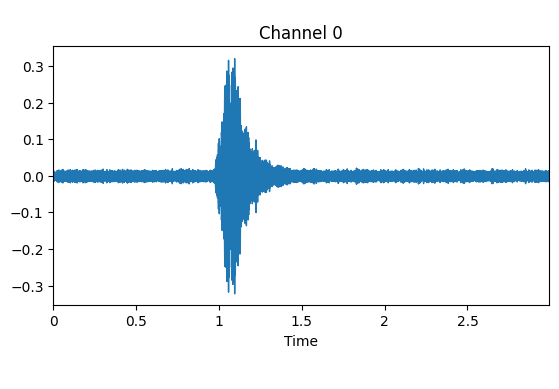

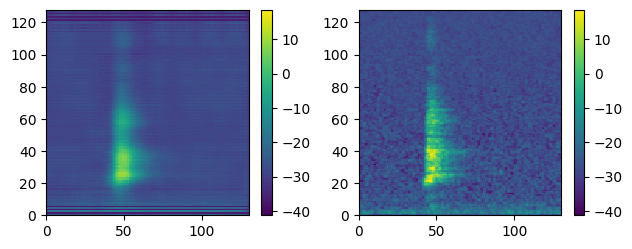

In [19]:
# EXPERIMENT 1: 
# 1) get a sample from test dataset (normalized Mel-scaled log spectrogram)
# 2) encode and decode it
# 3) plot the original and reconstructed Mel-scaled log spectrogram as well as the audio waveform

# Use a random index to extract the Mel-scaled normalized log spectrogram and its min and max values
random_index = int(np.random.random() * len(test_dataset))
sample_logspec_norm = torch.tensor(test_dataset['logspec'][random_index]).unsqueeze(0).unsqueeze(0)
min_val = test_dataset['min'][random_index]
max_val = test_dataset['max'][random_index]

sr = 22050

# denormalize the original Mel-scaled log spectrogram
sample_logspec = normalizer.denormalize(sample_logspec_norm, min_val, max_val)

# generate the time-domain audio weaveform from the original log spectrogram
sample_audio = logspec_to_audio(sample_logspec.numpy(), HOP_LENGTH)

# compute the reconstructed Mel-scaled log spectrogram
mu_logvar = model.encoder(sample_logspec_norm.to(device)).view(-1, 2, model.latent_space_dim)
z = mu_logvar[:, 0, :]
x_hat_norm = model.decoder(z).cpu().detach()

# denormalize the reconstructed Mel-scaled log spectrogram
x_hat = normalizer.denormalize(x_hat_norm, min_val, max_val)

loss = nn.MSELoss()
print("MSE Loss: " + str(loss(x_hat, sample_logspec)))

# generate the time-domain audio weaveform from the reconstructed log spectrogram
x_hat_audio = logspec_to_audio(x_hat.numpy(), HOP_LENGTH)

# plot reconstructed audio
plot_audio(output_folder, 'decoded_test_bark.wav', x_hat_audio, sr)

# plot original audio
plot_audio(output_folder, 'original_test_bark.wav', sample_audio, sr)

logspec_array = np.vstack([x_hat.numpy(), sample_logspec.numpy()])

# Plot log spectrograms
plot_logspec(logspec_array)

MSE Loss: tensor(225.8697)


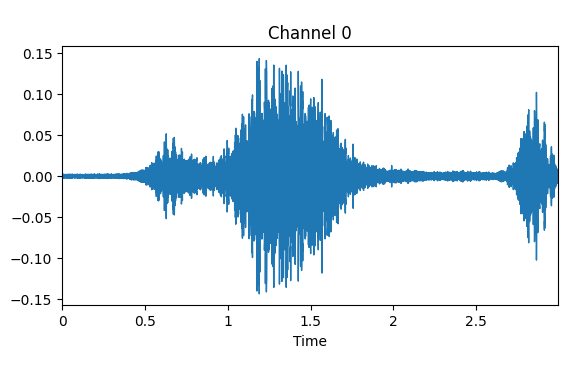

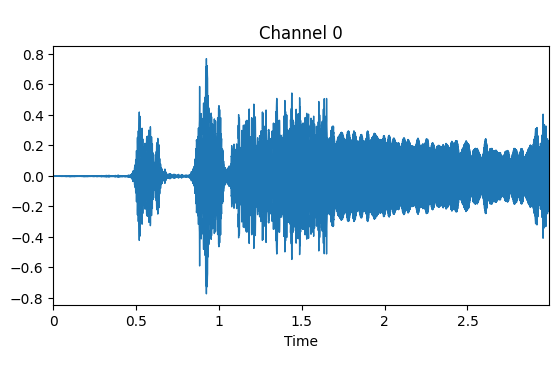

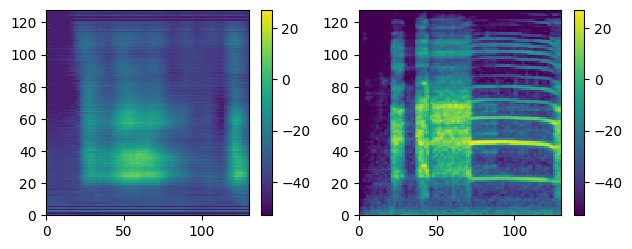

In [20]:
# EXPERIMENT 2: 
# try with a completely different classes of sound from ESC-10 dataset
# 1) get a sample from ESC-10 dataset (normalized Mel-scaled log spectrogram)
# 2) encode and decode it
# 3) plot the original and reconstructed Mel-scaled log spectrogram as well as the audio waveform

# Use a random index to extract the Mel-scaled normalized log spectrogram and its min and max values
random_index = int(np.random.random() * len(env_dataset.audio_ds))
sample_logspec_norm = torch.tensor(env_dataset.audio_ds['logspec'][random_index]).unsqueeze(0).unsqueeze(0)
min_val = env_dataset.audio_ds['min'][random_index]
max_val = env_dataset.audio_ds['max'][random_index]

sr = 22050

# denormalize the original Mel-scaled log spectrogram
sample_logspec = normalizer.denormalize(sample_logspec_norm, min_val, max_val)

# generate the time-domain audio weaveform from the original log spectrogram
sample_audio = logspec_to_audio(sample_logspec.numpy(), HOP_LENGTH)

# compute the reconstructed Mel-scaled log spectrogram
mu_logvar = model.encoder(sample_logspec_norm.to(device)).view(-1, 2, model.latent_space_dim)
z = mu_logvar[:, 0, :]
x_hat_norm = model.decoder(z).cpu().detach()

# denormalize the reconstructed Mel-scaled log spectrogram
x_hat = normalizer.denormalize(x_hat_norm, min_val, max_val)

loss = nn.MSELoss()
print("MSE Loss: " + str(loss(x_hat, sample_logspec)))

# generate the time-domain audio weaveform from the reconstructed log spectrogram
x_hat_audio = logspec_to_audio(x_hat.numpy(), HOP_LENGTH)

# plot decoded audio
plot_audio(output_folder, 'decoded_env_sound.wav', x_hat_audio, sr)

# plot original audio
plot_audio(output_folder, 'original_env_sound.wav', sample_audio, sr)

logspec_array = np.vstack([x_hat.numpy(), sample_logspec.numpy()])

# Plot log spectrograms
plot_logspec(logspec_array)

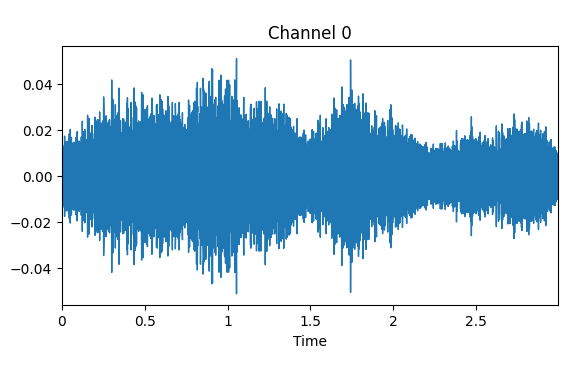

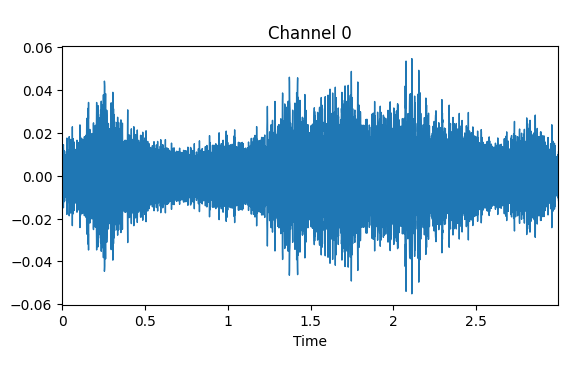

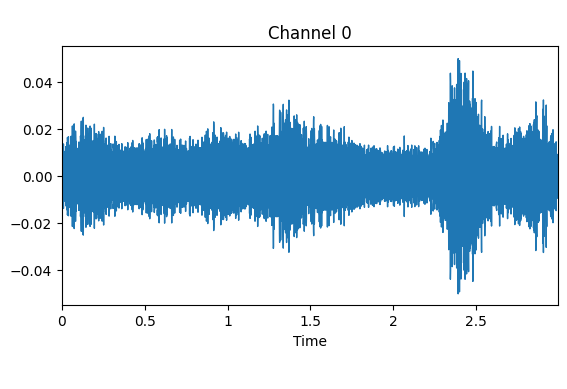

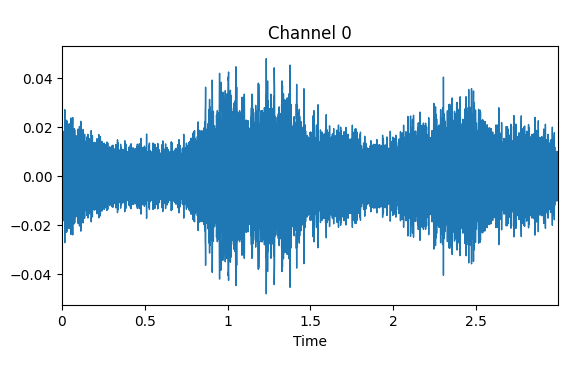

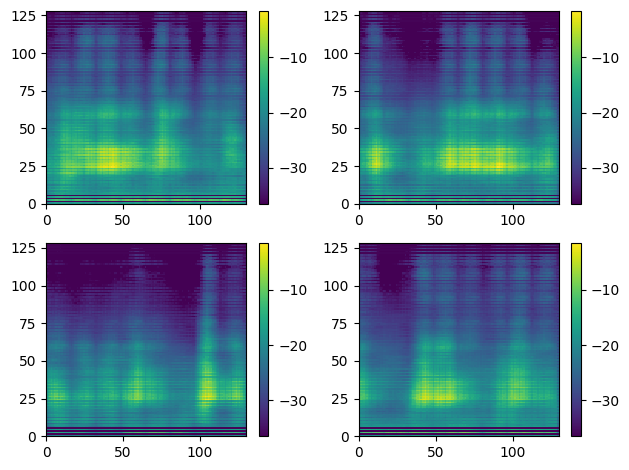

In [21]:
# EXPERIMENT 3: 
# test VAE generative property
# 1) generate samples from latent space (after the encoder)
# 2) decode them
# 3) plot the generated Mel-scaled log spectrograms as well as the audio waveforms

# The generative process does not seem to provide good results.
# A possibile explanation is that the training set was not so diversified to be able to scan all the latent space.

# parameters
sr = 22050

# Get a random index between 0 and len(train_dataset)
# use the random index to select a Mel-scaled log spectrogram min and max values pair 
# use the (min, max) for decoder output unnormalization
train_loader_dataset = train_loader.dataset.dataset.audio_ds
train_loader_indices = train_loader.dataset.indices
train_dataset = train_loader_dataset.loc[train_loader_dataset.index[train_loader_indices]]
train_dataset = train_dataset.dropna().reset_index(drop=True)
random_index = int(np.random.random() * len(train_dataset))

logspec_min = train_dataset['min'][random_index]
logspec_max = train_dataset['max'][random_index]

# Generating a few samples (N=4)
N = 4
z = torch.normal(0, 1, size=(N, model.latent_space_dim)).to(device)
fakes = model.decoder(z).cpu().detach().numpy() 

# denormalize the reconstructed Mel-scaled log spectrogram
fakes_denorm = normalizer.denormalize(fakes, logspec_min, logspec_max)

# plot audio
i = 1
for fake in fakes_denorm:
    fake_audio = logspec_to_audio(fake[np.newaxis, :, :, :], HOP_LENGTH)
    # write audio time samples
    fake_bark_filename = "fake_bark_" + str(i) + ".wav"
    fake_bark_path = os.path.join(output_folder, fake_bark_filename)
    sf.write(fake_bark_path, fake_audio, samplerate=sr)
    AudioTensor.create(fake_bark_path).show()

# Plot log spectrograms
plot_logspec(fakes_denorm)

/opt/homebrew/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([128, 130])) that is different to the input size (torch.Size([1, 1, 128, 130])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/var/folders/tt/c1w5rnl91l3bvv13d_l1jgrm0000gp/T/ipykernel_8814/3823481272.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_ds = test_bark_ds.append(test_env_ds, ignore_index=True)


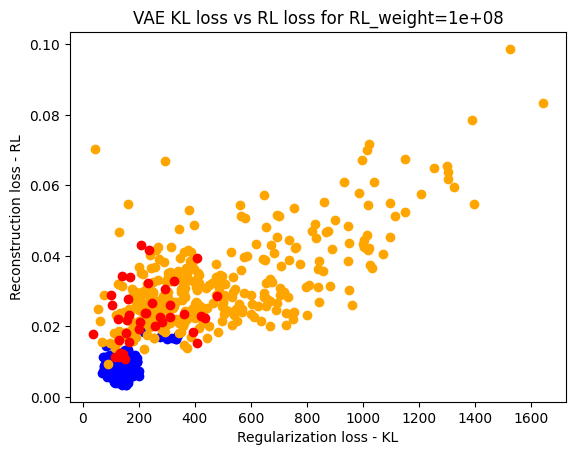

In [22]:
# computes the RL, KL and label arrays for test barks dataset and enviromental sounds dataset given RL_weight=1e08
RL_test_bark, KL_test_bark, mu_test_bark, logvar_test_bark, bark_labels = compute_RL_KL(model, 
                                                                                        device, 
                                                                                        normalizer, 
                                                                                        test_dataset)
RL_test_env, KL_test_env, _, _, env_labels = compute_RL_KL(model, 
                                                            device, 
                                                            normalizer, 
                                                            env_dataset.audio_ds)

# merge the three numpy arrays, add headers and transform the dictionary into pandas dataframe
# for both test barks dataset and enviromental sounds dataset
test_bark_data = {"RL": RL_test_bark,
                  "KL": KL_test_bark,
                  "class": bark_labels}

test_env_data = {"RL": RL_test_env,
                 "KL": KL_test_env,
                 "class": env_labels}

test_bark_ds = pd.DataFrame(test_bark_data)
test_env_ds = pd.DataFrame(test_env_data)

# merge the two dataframes
test_ds = test_bark_ds.append(test_env_ds, ignore_index=True)
test_ds = test_ds.dropna().reset_index(drop=True)
    
plot_RL_KL(test_ds, RL_weight)

## VAE regularization loss KL vs reconstruction loss RL

The 2-D scatterplot of VAE regularization loss KL vs reconstruction loss RL intuitively shows the accuracy of the VAE model as a One-Class audio classifier. </br>
</br>
However let's compute the model accuracy more formally. </br>
</br>
the 2-D scatterplot clearly shows this is a classification problem that can be solved with a linear regression (i.e. leveragin nn.linear() layers only) as the two classes are linearly separable.</br>
</br>
In order to verify that a linear model can perform a binary classification with a good accuracy we test two 3 layers MLP models, one with ReLU non linearities at each intermediate layer and one without non linearities. Both models have a final sigmoid() in order to output a one-dimensional probability used in the Binary Cross Entropy loss criteria during training. We compute the accuracy rounding this probability and comparing the output value (0 or 1) to the target class.

In [34]:
# tranform test_ds data in torch tensors.

# Features
X = torch.stack((torch.tensor(test_ds["KL"]), torch.tensor(test_ds["RL"])), dim=1).to(device)
# Labels
y = torch.FloatTensor((test_ds['class'] == 'bark').astype(np.int)).to(device)

/var/folders/tt/c1w5rnl91l3bvv13d_l1jgrm0000gp/T/ipykernel_8814/3131366582.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = torch.FloatTensor((test_ds['class'] == 'bark').astype(np.int)).to(device)


In [24]:
# setting optimizer parameters
learning_rate = 1e-3
weight_decay = 1e-5

# setting linear layers parameters
D = 2
C = 1
H1 = 100
H2 = 100

In [36]:
# define the model and send it to the device in use

linear_model = nn.Sequential(
    nn.Linear(D, H1),
    nn.Linear(H1, H2),
    nn.Linear(H2, C),
    nn.Sigmoid()
)
linear_model.to(device)

non_linear_model = nn.Sequential(
    nn.Linear(D, H1),
    nn.ReLU(),
    nn.Linear(H1, H2),
    nn.ReLU(),
    nn.Linear(H2, C),
    nn.Sigmoid()
)
non_linear_model.to(device)

# we use Binary Cross Entropy loss for our binary classification task
criterion = torch.nn.BCELoss()

In [26]:
from IPython import display

def train_model(model, criterion, lr, wd):

    # we use ADAM optimizer for parameters update
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    for t in range(1000):
    
        # Feed forward to get the output probabilities
        y_pred = model(X)
    
        # Compute the loss and accuracy
        loss = criterion(y_pred, y.unsqueeze(1))
        predicted = torch.round(y_pred)
        acc = (y.unsqueeze(1) == predicted).sum().float() / len(y)
        print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
        display.clear_output(wait=True)
    
        # zero the gradients before running the backward pass.
        optimizer.zero_grad()
    
        # Backward pass to compute the gradient of loss w.r.t our learnable params. 
        loss.backward()
    
        # Update params
        optimizer.step()

In [29]:
# train linear model
train_model(linear_model, criterion, learning_rate, weight_decay)

[EPOCH]: 999, [LOSS]: 0.287855, [ACCURACY]: 0.900


In [37]:
# train non linear model
train_model(non_linear_model, criterion, learning_rate, weight_decay)

[EPOCH]: 999, [LOSS]: 0.265673, [ACCURACY]: 0.902


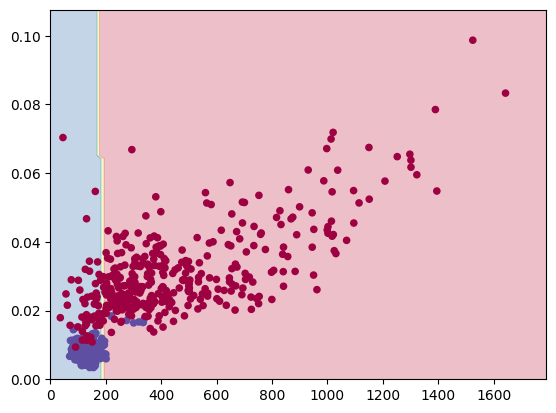

In [31]:
# Plot trained linear model
plot_model(X, y, linear_model)

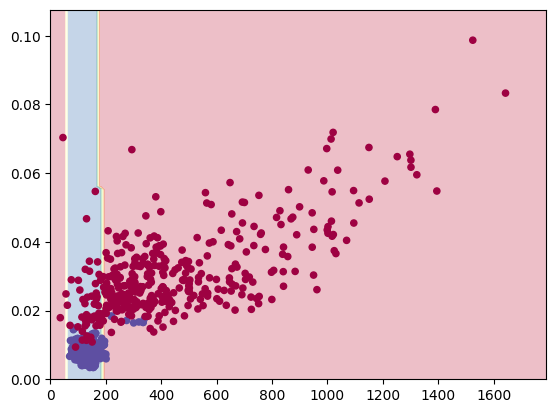

In [38]:
# Plot trained non linear model
plot_model(X, y, non_linear_model)

## References

### Mel-scaled spectrograms
1) https://towardsdatascience.com/learning-from-audio-the-mel-scale-mel-spectrograms-and-mel-frequency-cepstral-coefficients-f5752b6324a8
2) https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53
3) https://librosa.org/doc/main/generated/librosa.stft.html
4) https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html

### VAE theory
5) https://atcold.github.io/pytorch-Deep-Learning/en/week08/08-3/
6) http://adamlineberry.ai/vae-series/vae-theory
7) https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73

### VAE implementation
8) https://github.com/musikalkemist/generating-sound-with-neural-networks

### Early stopping:
9) https://page.mi.fu-berlin.de/prechelt/Biblio/stop_tricks1997.pdf

### ESC-10 enviromental sound dataset
10) https://github.com/karolpiczak/ESC-10